This notebook is a WIP (work in progress) notebook to redo `qh`, 
moving it away from it's current core of `py2http` and making it (hopefully) a better basis.

The better basis we want to have:
* use wrapping and routing tools of `i2`
* use `FastAPI` as the backend

Ideally, we'd like to facade our relationship with `FastAPI`, eventually.
But given the current context (new `i2mint` devs), we will not try to hard 
(not too the point of slowing us down too much).

Before `py2http`, there was `py2api`, and before that `flask_wrap`. 
We should look there for the good ideas, so we don't have to rethink them, or redo the same mistakes.


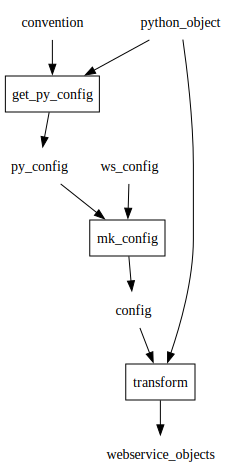

In [34]:
from meshed import code_to_dag

@code_to_dag
def i2i():
    webservice_objects = transform(python_object, config)
    py_config = get_py_config(python_object, convention)
    config = mk_config(py_config, ws_config)
    # config = mk_config(particular_config, convention)
i2i.dot_digraph()

# Refactoring a FastAPI app

We'll start with a simple `FastAPI` webservice, and gradually refactor towards 
increasingly more declarative architectures.

In [3]:
# We'll test our http service at every step using test_fastapi_refactor_app
from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app

# You need to specify what app (object) you're testing, but if you don't specify an 
# app, test_fastapi_refactor_app will test all the 
# fastapi_refactors.fastapi_refactor_** apps
test_fastapi_refactor_app(verbose=2)  # levels: verbose=0, 1, 2 


Testing app 1
    test_get_random_integer
    test_greeter
    test_get_store_list
    test_get_store_value
Testing app 2
    test_get_random_integer
    test_greeter
    test_get_store_list
    test_get_store_value


## 00: Base functionality

Here, we'll intoduce a few objects that will be used as the "functional backend" of our webservices.
There's a couple of functions and a `backend_mall`, which is a `dict` that will hold other `dict`s:
These are supposed to represent facades to persisted data, siloed by user. 
We'll use the the `get_store` function to get the data corresponding to a particular user.


In [5]:
from wip_qh.fastapi_refactors.fastapi_refactor_00 import (
    random_integer,
    greeter,
    backend_mall,
    get_user_data,
)

In [6]:
random_integer()

8

In [7]:
random_integer(40, 45)

43

In [8]:
greeter('Hello')

'Hello, world!'

In [9]:
print(greeter('hi', 'bob', n=4))

hi, bob!
hi, bob!
hi, bob!
hi, bob!


In [10]:
backend_mall

{'alice': {'fruit': {'apple': 1, 'banana': 2},
  'planets': {'mercury': 10, 'venus': 20, 'earth': 30}},
 'bob': {'food': {'apple': 1, 'broccoli': 2, 'carrot': 3},
  'cars': {'ford': 10, 'toyota': 20},
  'colors': {'red': 100}}}

In [11]:
store = get_user_data('alice')
list(store)

['fruit', 'planets']

In [12]:
store['fruit']

{'apple': 1, 'banana': 2}

## 01: The first a-la-mano webservice

The way to make a web service with `FastAPI`
--as with many python-based modern web service frameworks--
is to decorate functions to map them to webservice routes. 

In the case of the `backend_mall`, we map it to routes corresponding to operations we want to provide as web services:

```python
@app.get("/store_list/{user}")
def get_store_list(user: str):
    store = store_getter(user)

    return list(store)

@app.get("/store_get/{user}/{key}")
def get_store_value(user: str, key: str):
    store = store_getter(user)
    return store[key]

# etc.
```

In [9]:
# We'll test the app with this:
from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app

In [10]:
from wip_qh.fastapi_refactors.fastapi_refactor_01 import app

test_fastapi_refactor_app(app)

## 02: Factoring out the decorators

The first thing we'll do is to factor out the routing information, 
that is, the information carried by the decorators. 
There are two pieces of information there (at least in our example):
* the [http method](https://developer.mozilla.org/en-US/docs/Web/HTTP/Methods): `get` and `post` in our example, but there's also `put` and `delete` (and others, less frequent)
* the URL [path](https://www.watchguard.com/help/docs/help-center/en-US/Content/en-US/Fireware/proxies/http/http_req_url_paths_c.html)

So the first thing we'll do is to separate this information, mapping the decorated functions to them. 


In [8]:
from wip_qh.fastapi_refactors.fastapi_refactor_02 import app

test_fastapi_refactor_app(app)

## 03: Generalizing `apply_decorators_to_app` 


```python
def apply_decorators_to_app(app, configs):
    """Applying decorators based on the configs"""
    for function, config in configs.items():
        method = config['method']  # TODO: existence and value validation
        app_method = getattr(app, method)
        app_method(config['path'])(function)  # TODO: exitend to handle all app_method args
```

In [20]:
from wip_qh.fastapi_refactors.test_fastapi_refactor_01 import test_fastapi_refactor_app

['fastapi_refactor_00', 'fastapi_refactor_01', 'fastapi_refactor_02']

# Scrap

## Old stuff

In [2]:
from wip_qh.fastapi_refactors.fastapi_refactor_00 import StoreAccess

s = StoreAccess.from_uri()
s.write('test_key', 'test_value_1111')
s.read('test_key')

'test_value_1111'

In [ ]:
from wip_qh.store_dispatch_2 import app
from wip_qh.store_dispatch_2 import *

@app.get("/list/{uri}")
async def list_keys(uri: str):
    store = StoreAccess.from_uri(uri)
    return store.list()


@app.get("/read/{uri}/{key}")
async def read_key(uri: str, key: str):
    try:
        store = StoreAccess.from_uri(uri)
        return store.read(key)
    except KeyError:
        raise HTTPException(status_code=404, detail="Key not found")

@app.post("/write/{uri}")
async def write_key(uri: str, body: WriteRequestBody):
    store = StoreAccess.from_uri(uri)
    store.write(body.key, body.value)

app = mk_app(
    constructor,
    constructor_arg_name='uri',
    routes={
        'list': {'route': "/list/{uri}", 'args': None, 'method': 'get'},
        'read': {'route': "/read/{uri}/{key}", 'args': ['key'], 'method': 'get'},
        'write': {'route': "/read/{uri}", 'args': ['body.key', 'body.value'], 'method': 'post'},

    }
)
   

NameError: name 'app' is not defined

Hello world!
Hello world!
Hello world!
Hello world!


In [5]:
from fastapi.testclient import TestClient

from wip_qh.store_dispatch_2 import app

client = TestClient(app)

response = client.get("/list/test_uri")
response

<Response [422 Unprocessable Entity]>

In [ ]:
print(response.status_code)
response.json()

422


{'detail': [{'type': 'missing',
   'loc': ['query', 'args'],
   'msg': 'Field required',
   'input': None,
   'url': 'https://errors.pydantic.dev/2.5/v/missing'},
  {'type': 'missing',
   'loc': ['query', 'kwargs'],
   'msg': 'Field required',
   'input': None,
   'url': 'https://errors.pydantic.dev/2.5/v/missing'}]}

In [ ]:
from wip_qh.simple_fastapi_dispatch import app

client = TestClient(app)

r = client.get("/poke/")
assert r.json() == 'here is a peek'

r = client.get("/foo/")


TypeError: Sig.map_arguments() got an unexpected keyword argument 'x'